# Лабораторная работа № 3. Методы классификации данных
## Вариант 10
### Цель лабораторной работы – получение навыков работы с методами классификации.
##### Задания:
1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;

3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены;

6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

7. Заполните пропущенные значения в данных;

8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn as sk
import warnings
from pylab import rcParams
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.metrics import (auc, roc_curve, 
                             precision_recall_curve, 
                             average_precision_score)
from scipy import interp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

warnings.filterwarnings("ignore")

red = pd.read_csv('winequality-red.csv', sep = ';')
white = pd.read_csv('winequality-white.csv', sep =';')

##### Задание 1:
1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).

# Набор данных о качестве вина.
##### Скачать: Папка Данных, Описание Набора Данных.
#### Аннотация:
Включены два набора данных, связанных с образцами красного и белого вина Виньу Верде с севера Португалии. Цель состоит в том, чтобы смоделировать качество вина на основе физико-химических тестов (см. [Cortez et al., 2009], [Веб-ссылка]).

In [2]:
df =pd.DataFrame({'Data Set Characteristics:':['Multivariate'], 'Attribute Characteristics:':['Real'], 'Associated Tasks:':['Classification, Regression'], 'Number of Instances:':['4898'], 'Number of Attributes:':['12'], 'Missing Values?':['N/A'], 'Area:':['Business'], 'Date Donated':['2009-10-07'], 'Number of Web Hits:':['519077'] })
df

,Data Set Characteristics:,Attribute Characteristics:,Associated Tasks:,Number of Instances:,Number of Attributes:,Missing Values?,Area:,Date Donated,Number of Web Hits:
0,Multivariate,Real,"Classification, Regression",4898,12,N/A,Business,2009-10-07,519077


### Источник:
Пабло Кортес, Университет Минью, Гимарайнш, Португалия, http://www3.dsi.uminho.pt/pcortez
A. Cerdeira, F. Almeida, T. Matos and J. Reis, Комиссия по виноградарству региона Винью-Верде(CVRVV), Порту,
Португалия
@2009

### Информация о наборе данных:
Эти два набора данных относятся к красному и белому вариантам португальского вина "Винью Верде". Для получения более подробной нформации обратитесь к [Веб-ссылка] или к ссылке [Cortez et al., 2009]. Из-за проблем конфиденциальности и логистики доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, есть гораздо больше нормальных вин, чем отличных или плохих). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких превосходных или плохих вин. Кроме того, мы не уверены, что все входные переменные релевантны. Поэтому было бы интересно протестировать методы выбора функций.

### Информация об атрибутах:
Для получения дополнительной информации прочтите [Cortez et al., 2009].
Входные переменные (на основе физико-химических тестов):
1. фиксированная кислотность
2. летучая кислотность
3. лимонная кислота
4. остаточный сахар
5. хлориды
6. свободный диоксид серы
7. общий диоксид серы
8. плотность
9. рН
10. сульфаты
11. алкоголь
Выходная переменная (на основе сенсорных данных):
12. качество (оценка от 0 до 10)

### Соответствующие Документы:
П. Кортес, А. Сердейра, Ф. Алмейда, Т. Матос и Дж.Рейс. Моделирование предпочтений вина путем интеллектуального анализа данных по физико-химическим свойствам. В Системах Поддержки Принятия Решений Elsevier, 47(4):547-553, 2009.
Доступно по адресу: [Веб-ссылка]

### Запрос на цитирование:
Пожалуйста, включите эту цитату, если вы планируете использовать эту базу данных:
П. Кортес, А. Сердейра, Ф. Алмейда, Т. Матос и Дж.Рейс.
Моделирование предпочтений вина путем интеллектуального анализа данных по физико-химическим свойствам. В Системах Поддержки Принятия Решений Elsevier,
47(4):547-553, 2009.

##### Задание 2
2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;

In [3]:
white.count()

fixed acidity           4898
volatile acidity        4898
citric acid             4898
residual sugar          4898
chlorides               4898
free sulfur dioxide     4898
total sulfur dioxide    4898
density                 4898
pH                      4898
sulphates               4898
alcohol                 4898
quality                 4898
dtype: int64

In [4]:
white.drop_duplicates(inplace = True)
white.count()

fixed acidity           3961
volatile acidity        3961
citric acid             3961
residual sugar          3961
chlorides               3961
free sulfur dioxide     3961
total sulfur dioxide    3961
density                 3961
pH                      3961
sulphates               3961
alcohol                 3961
quality                 3961
dtype: int64

In [5]:
red.count()

fixed acidity           1599
volatile acidity        1599
citric acid             1599
residual sugar          1599
chlorides               1599
free sulfur dioxide     1599
total sulfur dioxide    1599
density                 1599
pH                      1599
sulphates               1599
alcohol                 1599
quality                 1599
dtype: int64

In [6]:
red.drop_duplicates(inplace = True)
red.count()

fixed acidity           1359
volatile acidity        1359
citric acid             1359
residual sugar          1359
chlorides               1359
free sulfur dioxide     1359
total sulfur dioxide    1359
density                 1359
pH                      1359
sulphates               1359
alcohol                 1359
quality                 1359
dtype: int64

##### Задание 3
3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

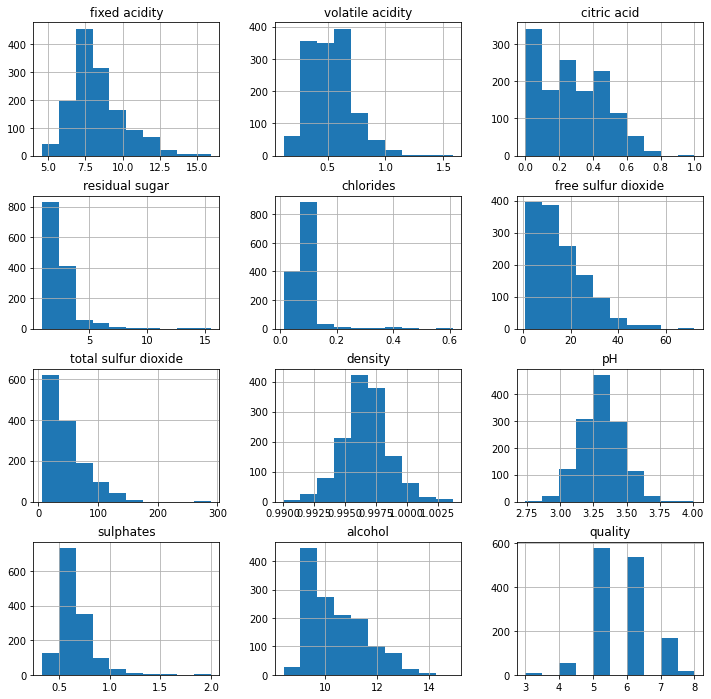

In [7]:
rcParams['figure.figsize'] = 12, 12
red.hist()

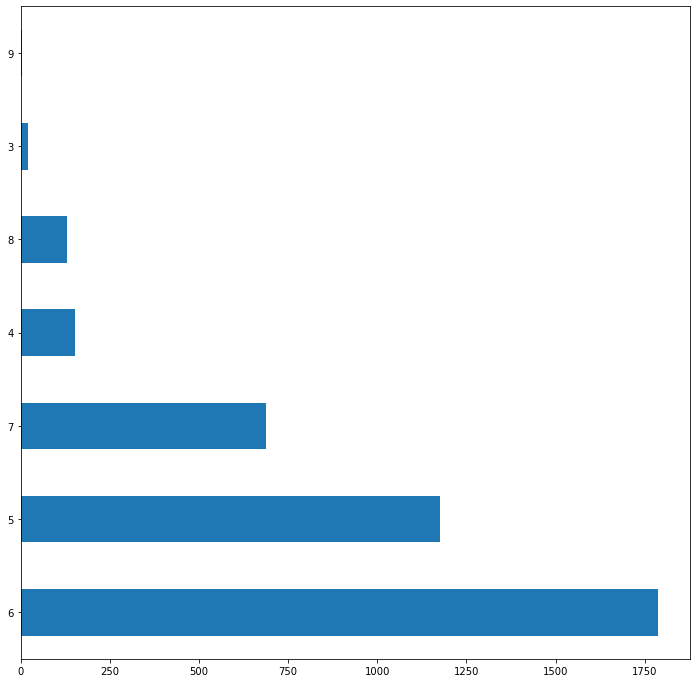

In [8]:
white['quality'].value_counts().plot.barh()
plt.show()

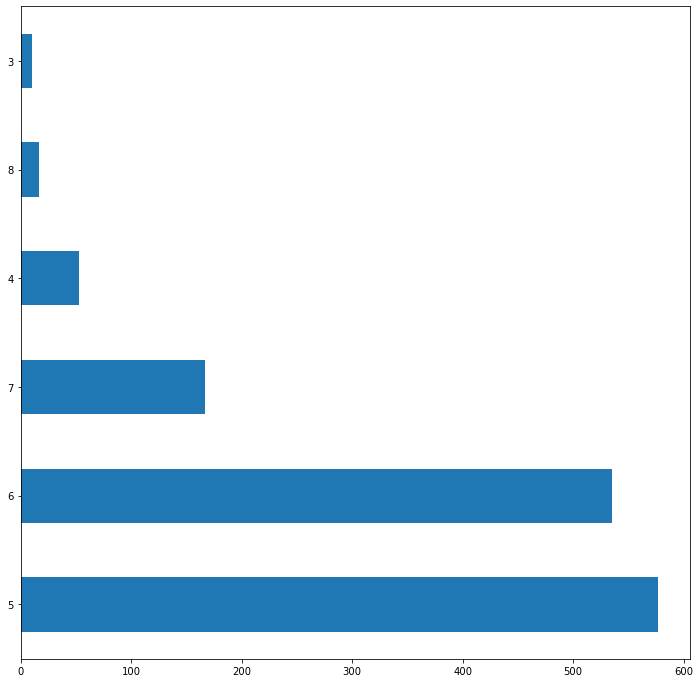

In [9]:
red['quality'].value_counts().plot.barh()
plt.show()

Соотношение количество элементов заметно отличается, поэтому будем считать, что классы несбалансированы.
Будем использовать PR-кривую, поскольку она дает адекватную оценку качества работы алгоритма, где классы несбалансированы.

##### Задание 4
4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);

In [10]:
numerical = []
for i in red.columns:
    if (red[i].dtype == np.float64 or red[i].dtype == np.int64):
        numerical.append(red[i].name)
numerical

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

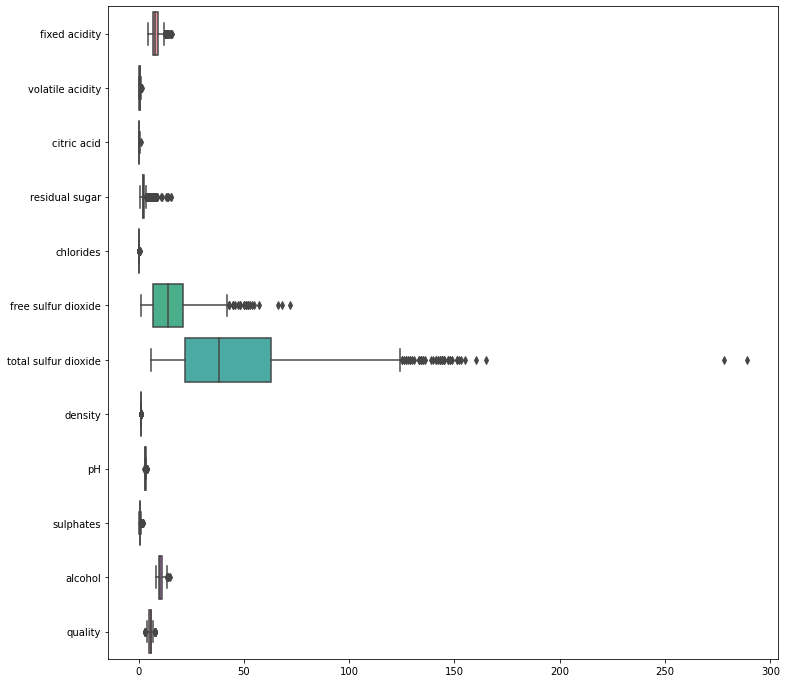

In [11]:
sn.boxplot(data = red[numerical], orient = 'h')
plt.show()

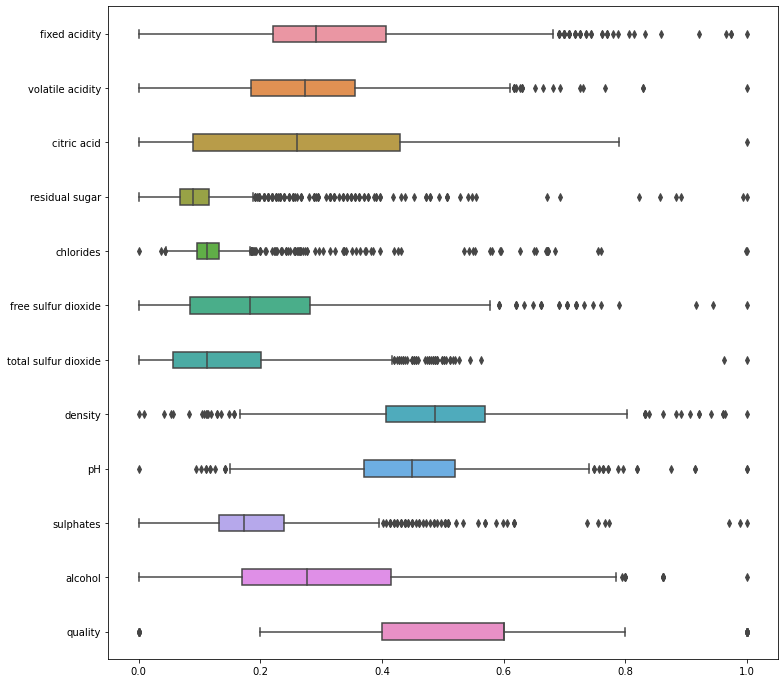

In [12]:
red_quality = red['quality']
scaler = MinMaxScaler() #Нормализация
red[numerical] = scaler.fit_transform(red[numerical].values.astype(float))
sn.boxplot(data = red[numerical], width=0.3, orient = 'h')
red['quality'] = red_quality

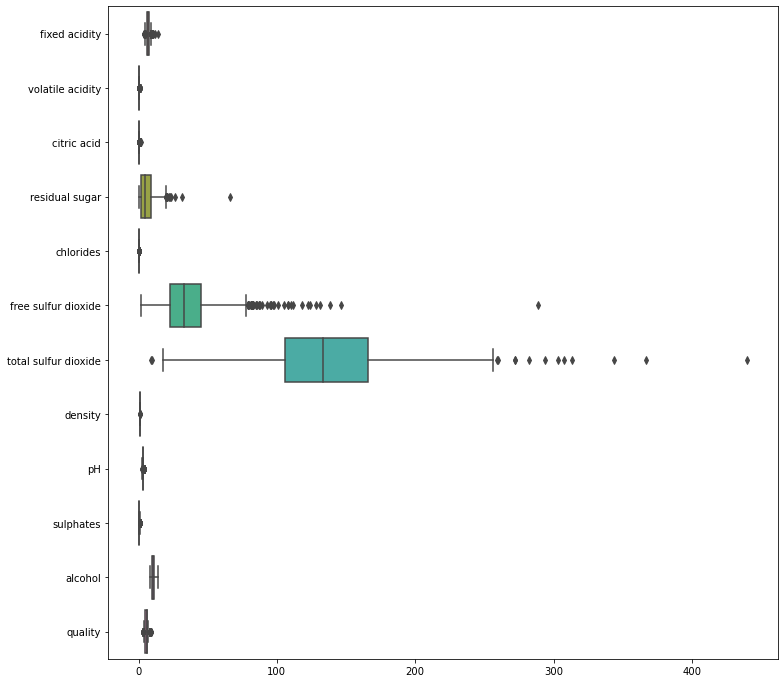

In [13]:
sn.boxplot(data = white[numerical], orient = 'h')
plt.show()

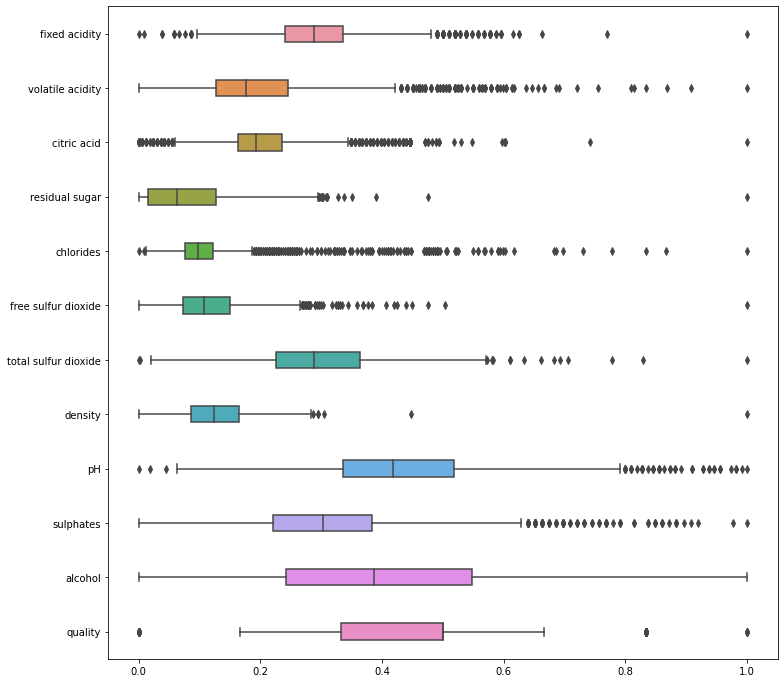

In [14]:
white_quality = white['quality']
scaler = MinMaxScaler()
white[numerical] = scaler.fit_transform(white[numerical].values.astype(float))
sn.boxplot(data = white[numerical], width=0.3, orient = 'h')
white['quality'] = white_quality

##### Задание 5
5. Выполните замену категориальных признаков

In [15]:
categorical = []
for i in red.columns:
    if (red[i].dtype != np.float64 and red[i].dtype != np.int64):
        categorical.append(red[i].name)
categorical

[]

В таблице нет категориальных признаков

##### Задание 6
Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);

fixed acidity           0.119024
volatile acidity       -0.395214
citric acid             0.228057
residual sugar          0.013640
chlorides              -0.130988
free sulfur dioxide    -0.050463
total sulfur dioxide   -0.177855
density                -0.184252
pH                     -0.055245
sulphates               0.248835
alcohol                 0.480343
quality                 1.000000
Name: quality, dtype: float64


['fixed acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates']

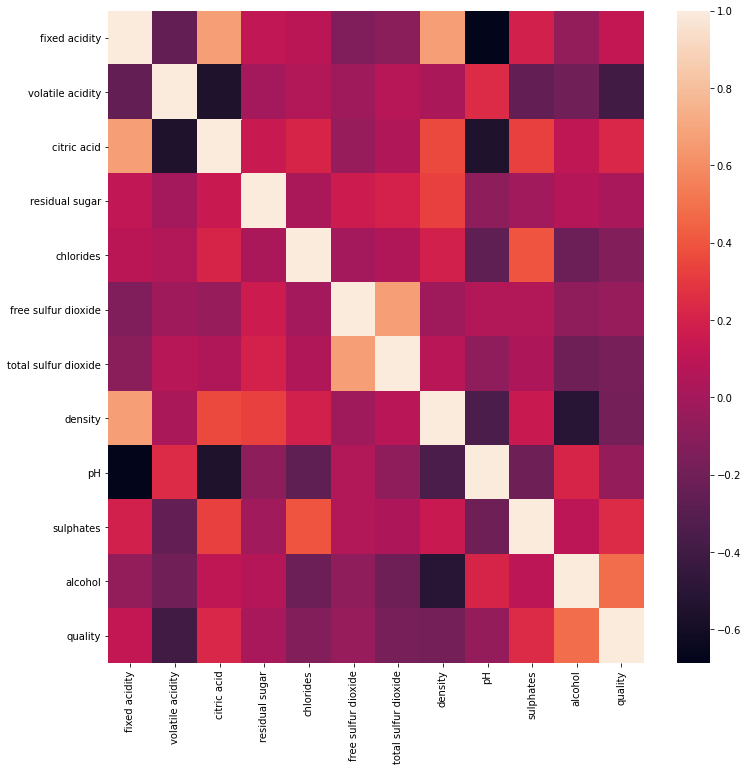

In [16]:
red_linear = red.copy()
corr_matrix = red_linear.corr()
sn.heatmap(corr_matrix);
print(corr_matrix['quality'])

to_drop = []
for i in corr_matrix.columns:
    if (abs(corr_matrix['quality'][i]) < 0.25):
        to_drop.append(corr_matrix[i].name)
to_drop

fixed acidity          -0.124636
volatile acidity       -0.190678
citric acid             0.007065
residual sugar         -0.117339
chlorides              -0.217739
free sulfur dioxide     0.010507
total sulfur dioxide   -0.183356
density                -0.337805
pH                      0.123829
sulphates               0.053200
alcohol                 0.462869
quality                 1.000000
Name: quality, dtype: float64


['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'pH',
 'sulphates']

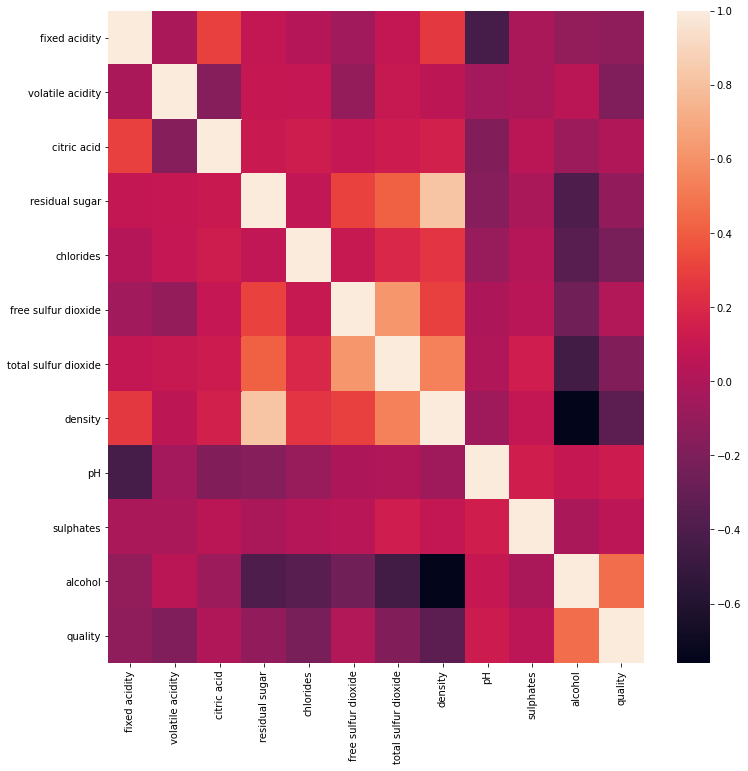

In [17]:
white_linear = white.copy()
corr_matrix = white_linear.corr()
sn.heatmap(corr_matrix);
print(corr_matrix['quality'])

to_drop = []
for i in corr_matrix.columns:
    if (abs(corr_matrix['quality'][i]) < 0.25):
        to_drop.append(corr_matrix[i].name)
to_drop

In [18]:
red_linear.drop(to_drop , axis = 1, inplace = True)
red_linear

,density,alcohol,quality
0,0.567548,0.153846,5
1,0.494126,0.215385,5
2,0.508811,0.215385,5
3,0.582232,0.215385,6
5,0.567548,0.153846,5
...,...,...,...
1593,0.472834,0.169231,6
1594,0.354626,0.323077,5
1595,0.370778,0.430769,6
1597,0.396476,0.276923,5


In [19]:
white_linear.drop(to_drop , axis = 1, inplace = True)
white_linear

,density,alcohol,quality
0,0.267785,0.129032,6
1,0.132832,0.241935,6
2,0.154039,0.338710,6
3,0.163678,0.306452,6
6,0.150183,0.258065,6
...,...,...,...
4893,0.077694,0.516129,6
4894,0.150183,0.258065,5
4895,0.104685,0.225806,6
4896,0.030461,0.774194,7


##### Задание 7
7. Заполните пропущенные значения в данных;

In [20]:
red.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [21]:
white.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Пропущенных данных нет

##### Задание 8
8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

In [22]:
x = np.array(red.drop('quality', axis=1)) # Данные на данные для обучения и теста
y = np.array(red['quality']) 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5, random_state = 0)
print(x_train.shape)
print(x_test.shape)

(679, 11)
(680, 11)


###### Классификатор бинарного рещающего дерева

In [23]:
dtc = DecisionTreeClassifier()
params = {'max_depth': list(range(1,5)), 'max_features': list(range(1,5))} # Найдем оптимальные глубину и количества 

dtc_grid = GridSearchCV(dtc, params)
dtc_grid.fit(x_train, y_train)

best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_
print('best train score:', best_score, 
      '\t at features number:', best_features,
      '\t at depth:', best_depth)

dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)# Сам классификатор
dtc.fit(x_train, y_train)
best_score  = np.mean(y_test == dtc.predict(x_test))
print('test score: ', best_score)
dtc.predict(x_test)

best train score: 0.553714596949891 	 at features number: 3 	 at depth: 3
test score:  0.5411764705882353


array([6, 5, 5, 6, 7, 6, 6, 5, 6, 6, 5, 6, 6, 5, 7, 6, 5, 5, 6, 6, 5, 5,
       6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 6, 6, 6, 6, 5, 6, 5, 5, 6, 6, 6, 7,
       6, 7, 5, 5, 6, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6, 6, 5, 5, 6, 5, 6, 5,
       5, 6, 5, 6, 5, 6, 6, 5, 7, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 5, 6,
       6, 7, 7, 6, 5, 6, 5, 6, 6, 6, 5, 6, 6, 6, 7, 6, 6, 5, 6, 6, 7, 5,
       6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 7, 6,
       6, 5, 5, 6, 7, 6, 6, 5, 6, 5, 6, 5, 5, 6, 6, 5, 6, 6, 5, 5, 5, 6,
       6, 6, 6, 6, 7, 6, 5, 7, 5, 5, 7, 5, 5, 6, 6, 6, 5, 6, 5, 6, 5, 5,
       6, 5, 5, 5, 6, 6, 5, 5, 6, 5, 5, 6, 5, 6, 5, 6, 6, 5, 5, 6, 6, 5,
       5, 6, 5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 5, 5, 6, 6, 5, 6, 6, 5, 6, 6, 5, 6, 7, 6, 6, 6, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 5, 6, 6, 5, 5, 6, 5, 6, 6, 5, 6, 6, 6, 6, 5, 5, 6,
       6, 5, 6, 5, 6, 5, 5, 6, 5, 6, 7, 6, 5, 5, 6, 6, 5, 6, 6, 6, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 5, 5, 5, 6, 7, 5, 6,

###### Классификатор K ближайших соседей

In [24]:
rnc = RadiusNeighborsClassifier(outlier_label= 1) # Найдем оптимальный радиус для классификатора ближайших соседей

params = {'radius': np.arange(0, 10, 0.1)}

rnc_grid = GridSearchCV(rnc, params)
rnc_grid.fit(x_train, y_train)

best_radius = rnc_grid.best_estimator_.radius
best_score = rnc_grid.best_score_
print('best train score:', best_score, '\t at radius:', best_radius)

rnc = RadiusNeighborsClassifier(outlier_label= 1, radius=best_radius) # Сам классификатор
rnc.fit(x_train, y_train)
best_score  = np.mean(y_test  == rnc.predict(x_test))
print('test score: ', best_score)

best train score: 0.5463725490196077 	 at radius: 0.5
test score:  0.5455882352941176


In [25]:
from sklearn.metrics import accuracy_score
classifier = RadiusNeighborsClassifier(radius=0.9, n_jobs=-1, outlier_label=1).fit(x_train, y_train)
pred = classifier.radius_neighbors(x_test)[0]
y_test = label_binarize(y_test, classes=[5, 6, 7, 4, 8, 3])
for i in range(len(pred)):
    pred[:][i] = min(pred[:][i]), max(pred[:][i]), np.mean(pred[:][i])
pred[:][73]

(0.10059479626005732, 0.8929873545165999, 0.5230192610480642)

In [26]:
class MyRadiusNeighborsClassifier(RadiusNeighborsClassifier):
        
    def predict_proba(self, X_test, X_train, y_train):
      
        runs = 25
        dr = (2*self.radius/runs)    
        
        radiuses = [dr*i for i in range(runs)]  
        percentage = [i/runs for i in range(runs)]
        percentage = sorted(percentage, reverse=True)
        probas = np.ndarray((len(y_test),6), dtype=np.float)
        for i in range(len(probas)):
            probas[i] = [5, 6, 7, 4, 8, 3]
        
        for i, radius in enumerate(radiuses):
            if i==0:
                rnc_temp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_temp.fit(X_train, y_train).predict(X_test)
                continue
            else:
                predict_second = predict_first
                rnc_tmp = RadiusNeighborsClassifier(radius, outlier_label=1)
                predict_first = rnc_tmp.fit(X_train, y_train).predict(X_test)
        
            for j, (p1, p2) in enumerate(zip(predict_first, predict_second)):
                if p1!=p2:
                    probas[j,0] = percentage[i]
                    probas[j,1] = 1-probas[j,0]
                
        return probas

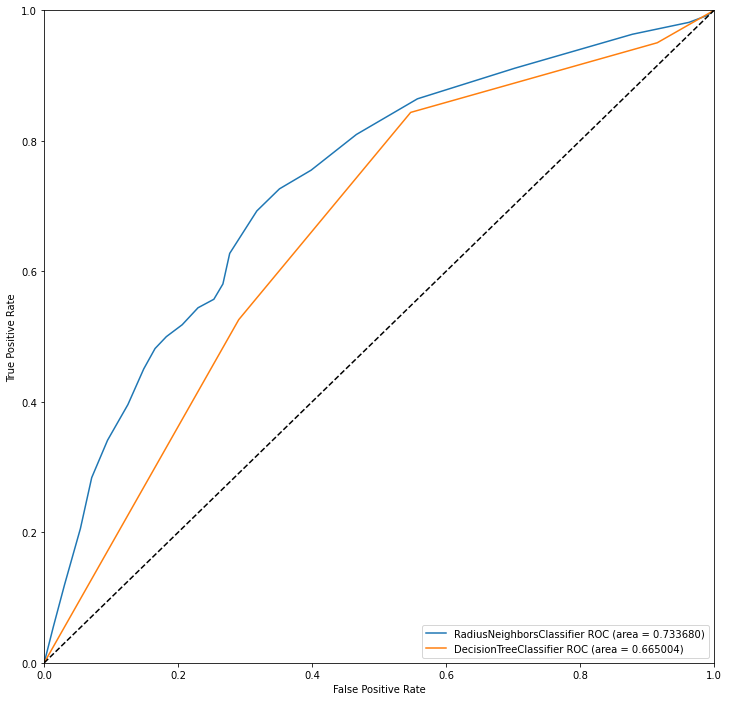

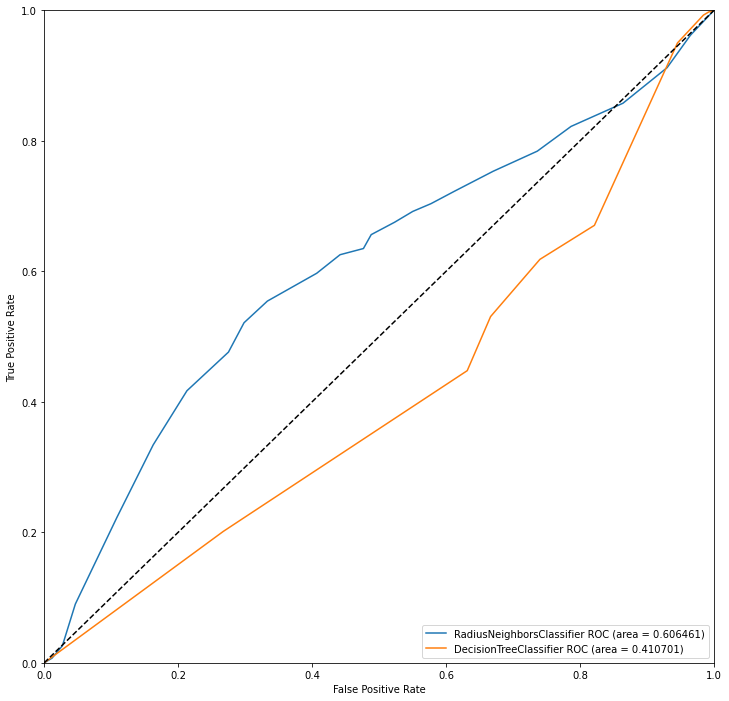

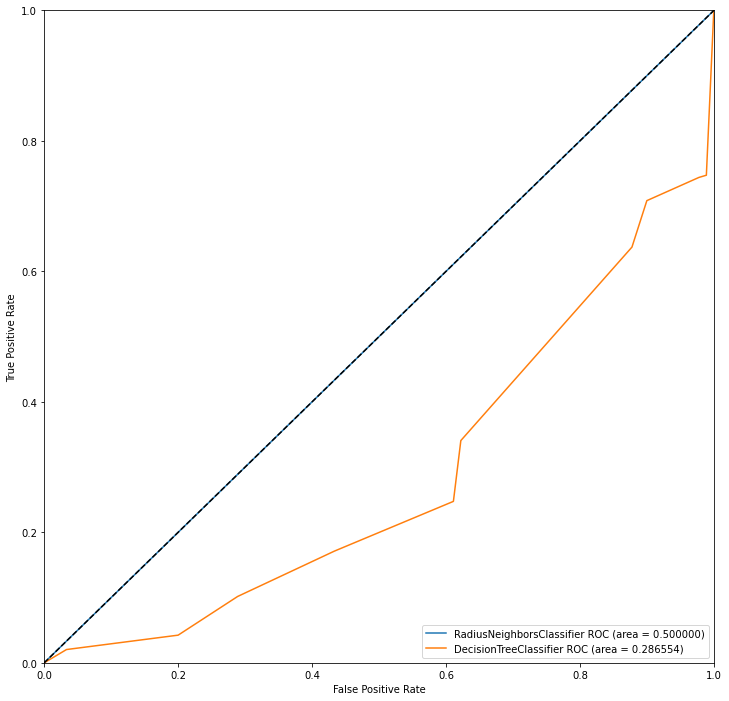

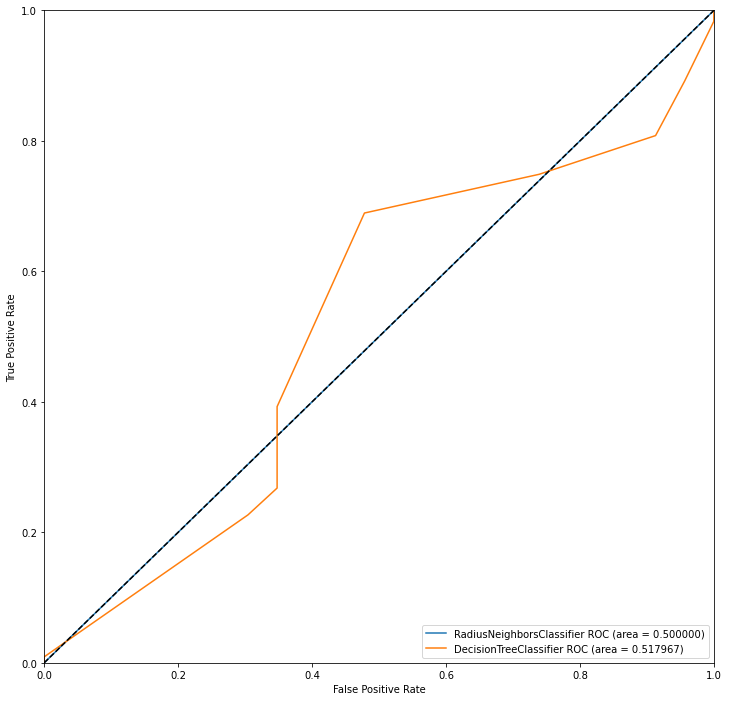

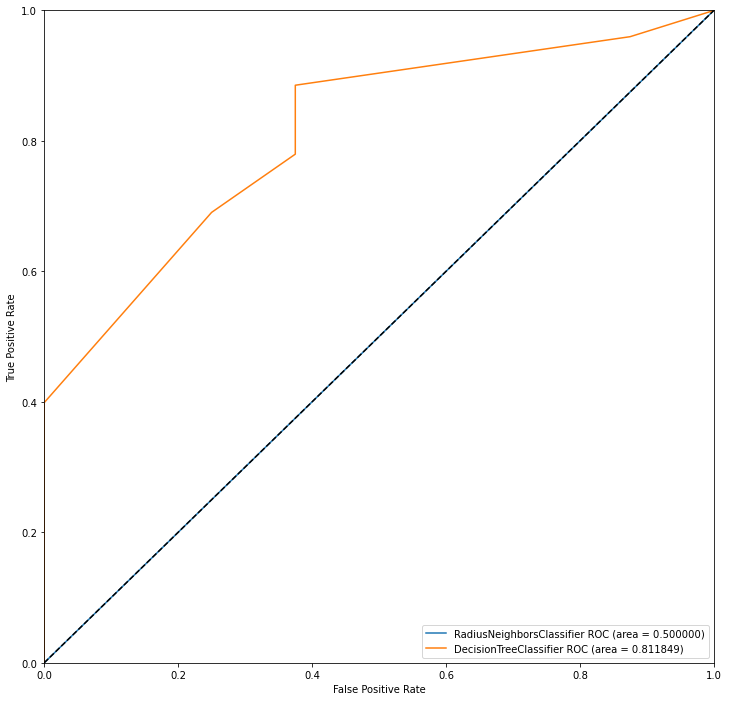

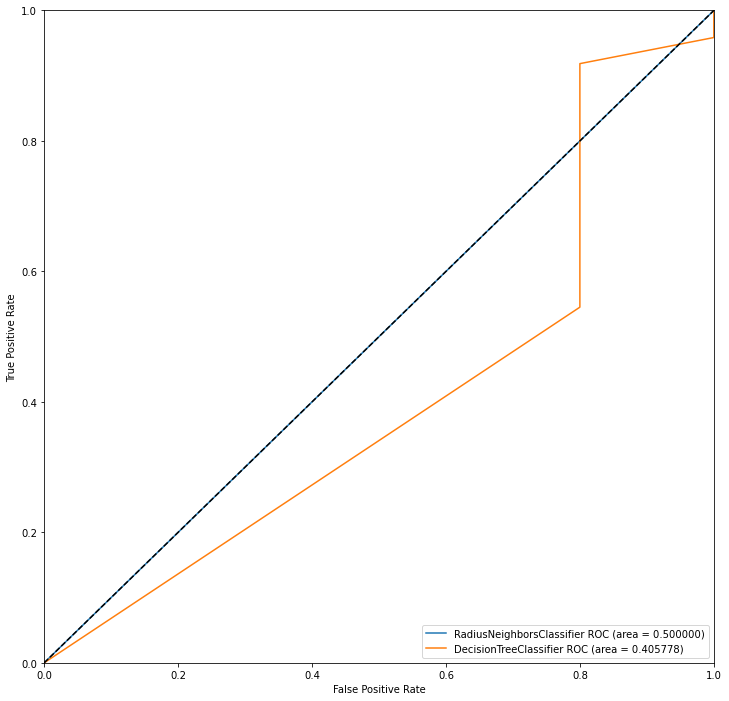

In [27]:
mrnc = MyRadiusNeighborsClassifier(outlier_label=1, radius=best_radius)
probas_mrnc = mrnc.predict_proba(x_test, x_train, y_train)

dtc = DecisionTreeClassifier(max_depth=4, max_features=2)
probas_dtc = dtc.fit(x_train, y_train).predict_proba(x_test)

for i in range(6):
    tpr, fpr, thresholds = roc_curve(y_test[:, i], -probas_mrnc[:,i])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('RadiusNeighborsClassifier', roc_auc)) 

    tpr, fpr, thresholds = roc_curve(y_test[:, i], -probas_dtc[:, i])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %f)' % ('DecisionTreeClassifier', roc_auc))  

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4, fontsize='medium')
    plt.show()

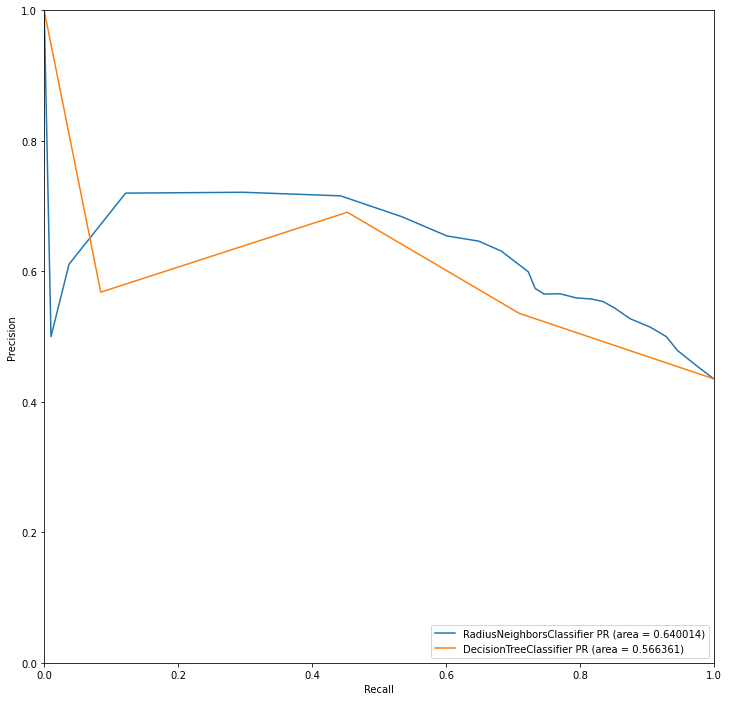

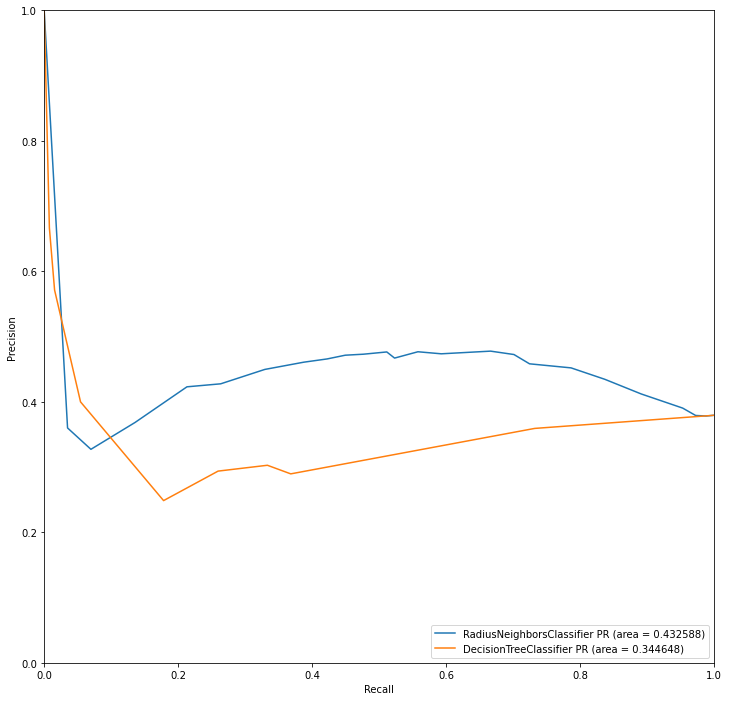

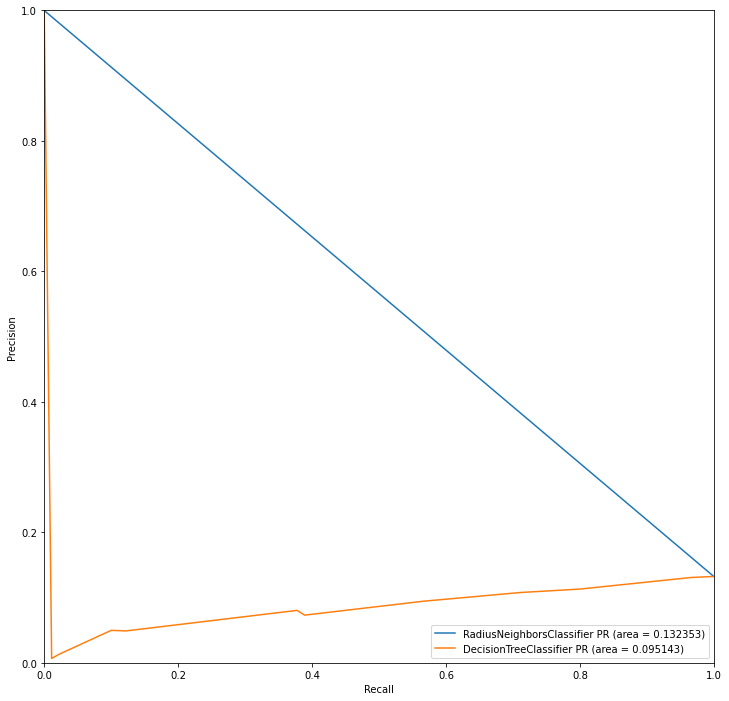

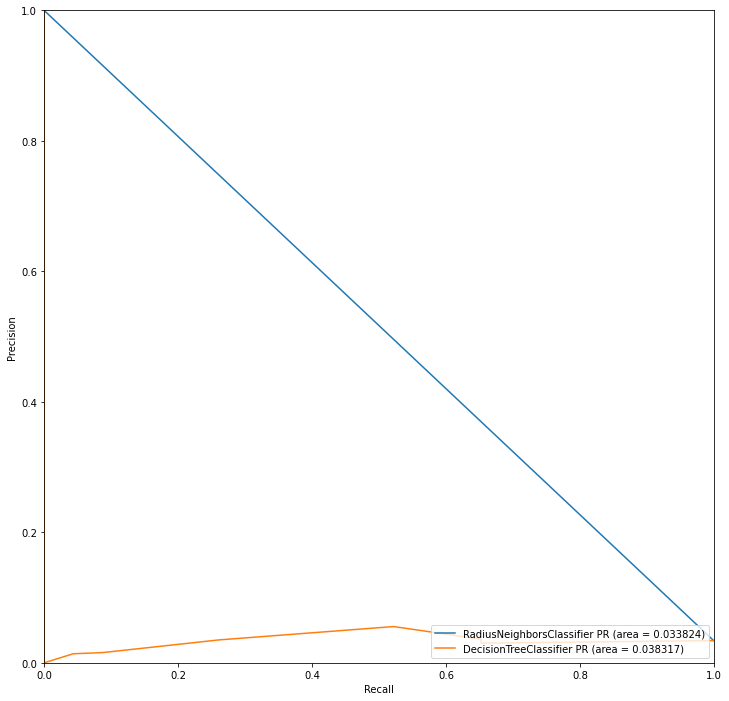

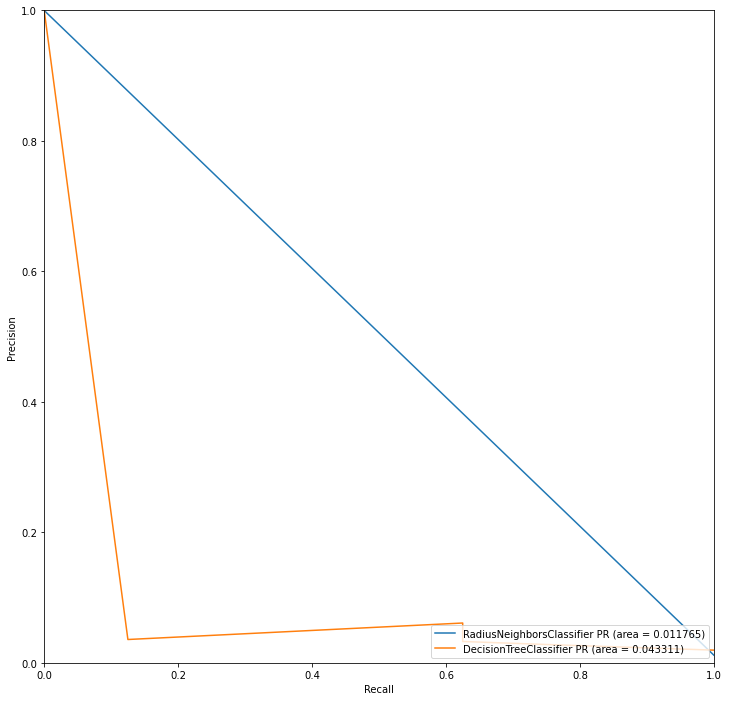

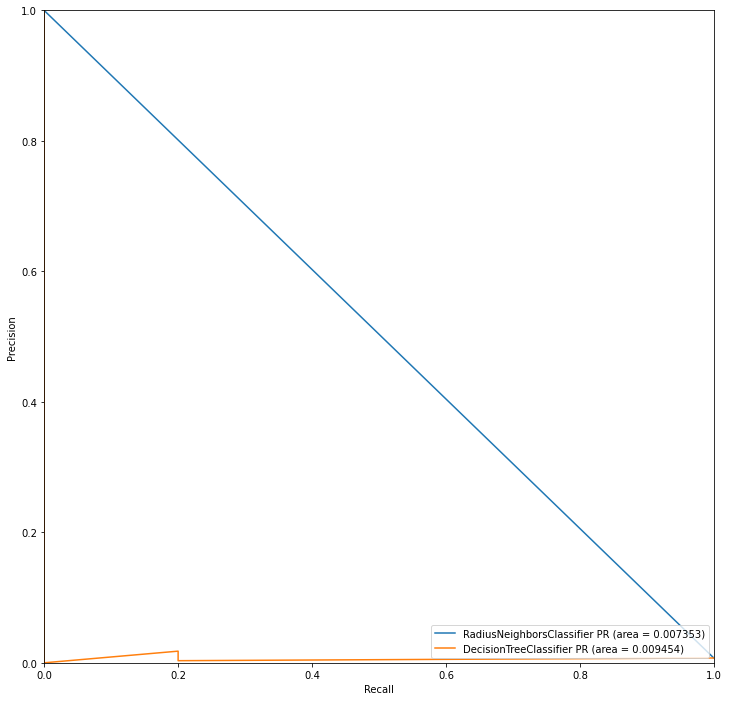

In [28]:
for i in range(6):
    precision, recall, thresholds = precision_recall_curve(y_test[:,i], probas_mrnc[:,i]) # K соседей
    aps_mrnc1 = average_precision_score(y_test[:,i],probas_mrnc[:,i])
    plt.plot(recall, precision, label='%s PR (area = %f)' % ('RadiusNeighborsClassifier', aps_mrnc1)) 

    precision, recall, thresholds = precision_recall_curve(y_test[:,i], probas_dtc[:,i]) # Решающее дерево
    aps_dtc1 = average_precision_score(y_test[:,i],probas_dtc[:,i])
    plt.plot(recall, precision, label='%s PR (area = %f)' % ('DecisionTreeClassifier',  aps_dtc1)) 

    plt.xlabel('Recall') # Вывод графика
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc=4, fontsize='medium')
    plt.show()

Классификаторы "Бинарное рещающее дерево" и "Метод k ближайших соседей" примерно имеют одинаковые показатели качества относительно PR и ROC кривых. Данные классификаторы на довольно посредственном уровне справляются со своей задачей, так как их точность ≈0.5